## ST1504 Deep Learning CA2 

## Part A:  GAN

# Background Information

In the world where data is very important, there are certain information that is sensitive or private. Using GAN allow us to generate new and unseen images which can be used for training of other models etc.


The Extended MNIST (EMNIST) dataset is an extension of the original MNIST dataset to include handwritten letters and digits. It is designed to serve as a benchmark dataset for handwritten recognition tasks. 
* This dataset contains letters from A to Z, thus having 26 classes. 
* Each image in the dataset is a 28x28 pixel grayscale image, similar to the MNIST dataset.
* There are total of 99040 rows with 785 columns (Excluding invalid labels, 88800 rows with 785 columns)

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

### Load the dataset

In [2]:
df=pd.read_csv('emnist-letters-train.csv')
df

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99034,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99035,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


### Filtering out invalid labels

In [3]:
# Filter out rows with label -1
df = df[df.iloc[:, 0] != -1]

# Proceed with extracting labels and pixel values
labels = df.iloc[:, 0].values
pixel_values = df.iloc[:, 1:].values
labels.shape


(88799,)

## Plotting images

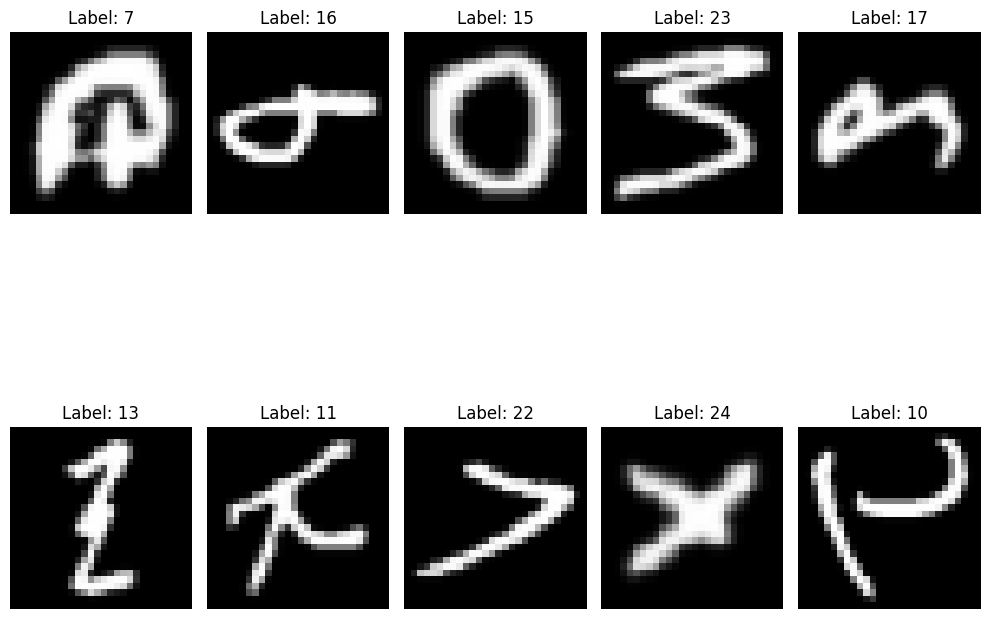

In [4]:
# Normalize the pixel values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
images = scaler.fit_transform(pixel_values)

# Reshape images to 28x28
images = images.reshape(-1, 28, 28, 1)

num_images = 10

# Create a figure with 5x2 subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Loop through the first 10 images
for i in range(num_images):
    row, col = divmod(i, 5)  # Determine the row and column
    axes[row, col].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

### From the images above, we cannot tell whether the images matches the actual letter. Hence, we need to find ways to make it into an actual letter. Analysing the images, We decided to do it by transposing the images.

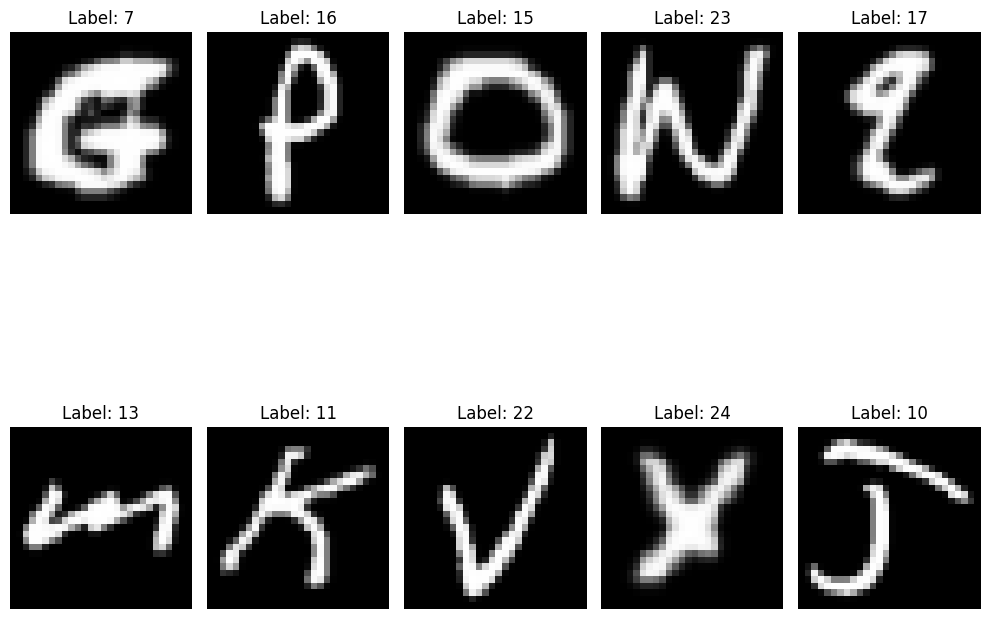

In [5]:
# Transpose all images
transposed_images = np.array([np.transpose(image.reshape(28, 28)) for image in images])

num_images = 10

# Create a figure with 5x2 subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Loop through the first 10 images
for i in range(num_images):
    row, col = divmod(i, 5)  # Determine the row and column
    axes[row, col].imshow(transposed_images[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

### We can now identify which letter each image represents.

## Checking Class distribution

When training a machine learning model, it is always important to check the distribution of the different
classes in the dataset. This will inform us which metrics is the best to use and if anything is needed to
balance the classes.

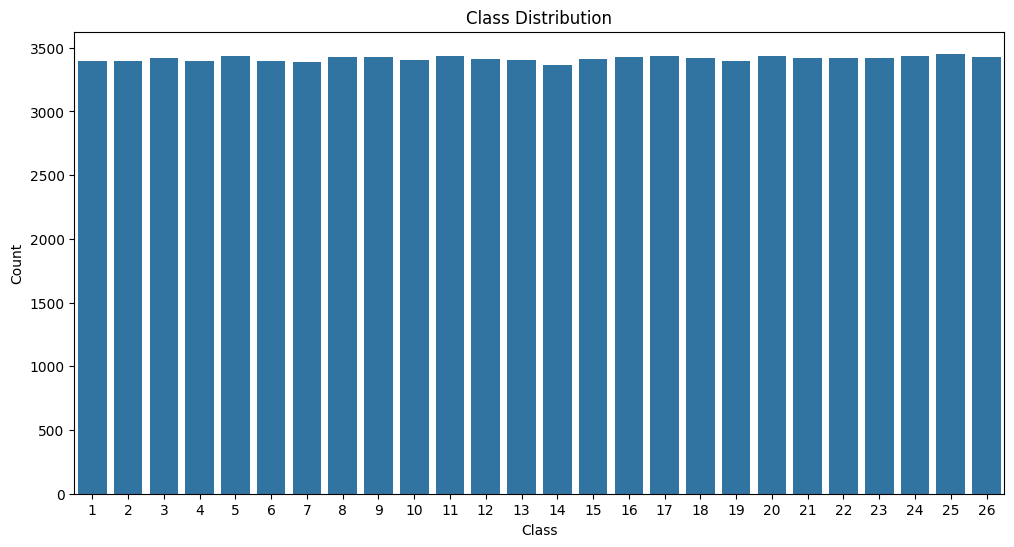

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### As we can see from the count plot, the distribution of the images is even. This means that there will be no biases towards one particular class.

## Image Pixel Distribution

We need to know the pixel intensity and know the distribution of pixels

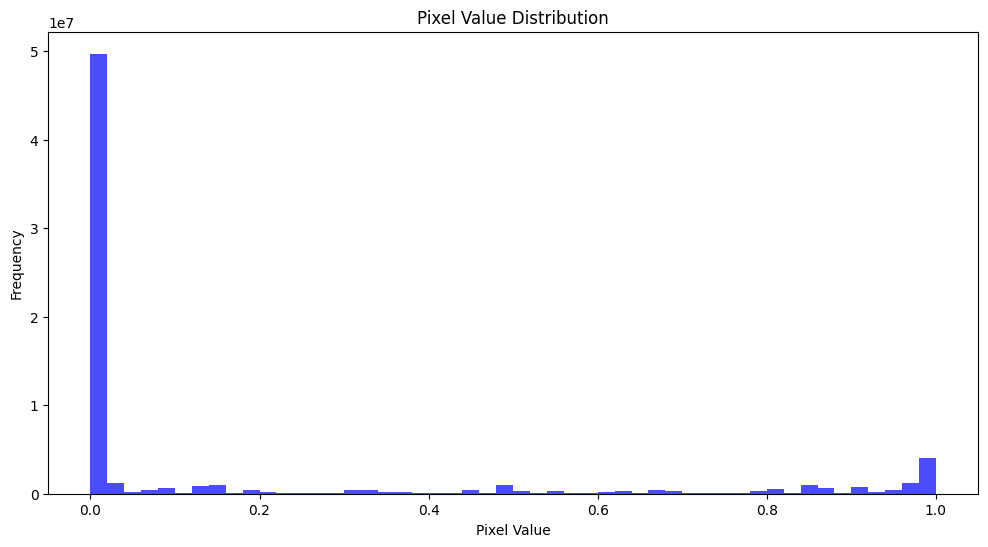

In [7]:
# Plot pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(transposed_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

### According to pixel value distrubution, it seems the majority of the image are black, likely due to the background being black, and there seems to a small peak at 1.0 likely due to the strokes of the character

Imbalance in Pixel Distribution:

The GAN might focus too much on generating the black background and not enough on the important features (strokes).

Training Challenges:

The discriminator may easily distinguish between real and generated images based on the predominance of black pixels, making it harder for the generator to improve

## Cropping images to reduce background

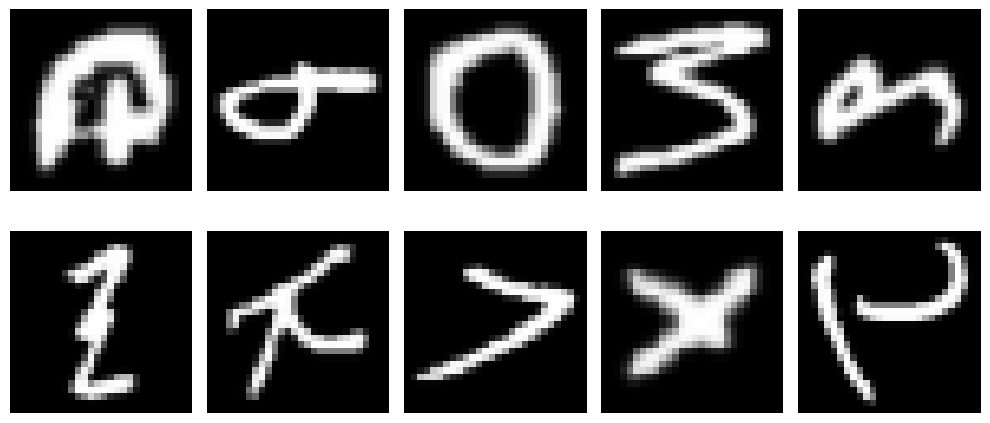

In [8]:
from PIL import Image, ImageOps
import numpy as np

def pad_and_resize(image, target_size=(28, 28), padding_color=0):
    # Convert to PIL Image
    pil_img = Image.fromarray((image * 255).astype(np.uint8))
    
    # Calculate padding to make the image square
    width, height = pil_img.size
    max_dim = max(width, height)
    delta_w = max_dim - width
    delta_h = max_dim - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    
    # Add padding
    padded_img = ImageOps.expand(pil_img, padding, fill=padding_color)
    
    # Resize to target size
    resized_img = padded_img.resize(target_size)
    
    # Convert back to numpy array
    return np.array(resized_img) / 255.0

# Apply to all images
processed_images = np.array([pad_and_resize(img.reshape(28, 28)) for img in images])

# Visualize some processed images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(processed_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


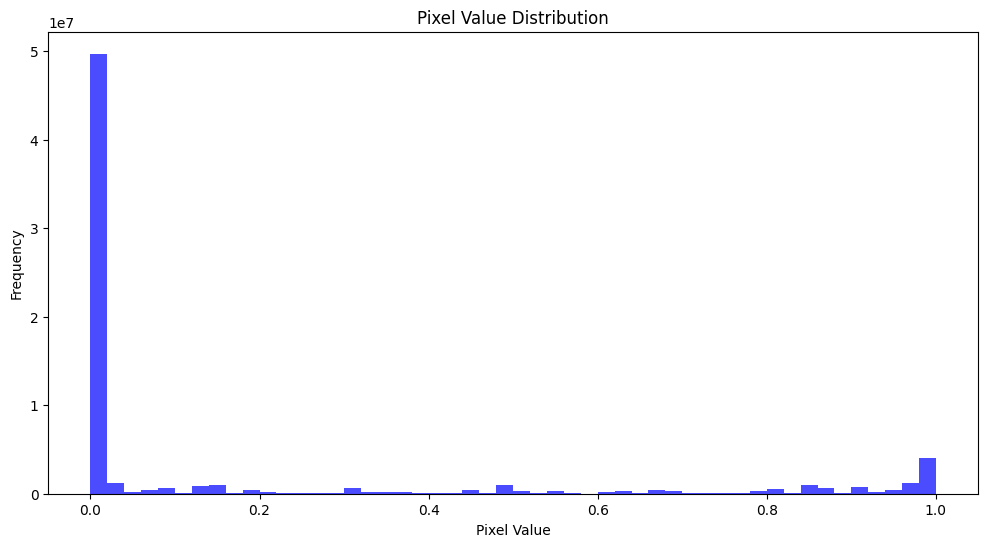

In [9]:
# Plot pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(processed_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

## Image Averaging

Image averaging involves stacking multiple photos on top of each other and averaging them together. The main purpose is to reduce noise in the images, thereby improving their overall quality.

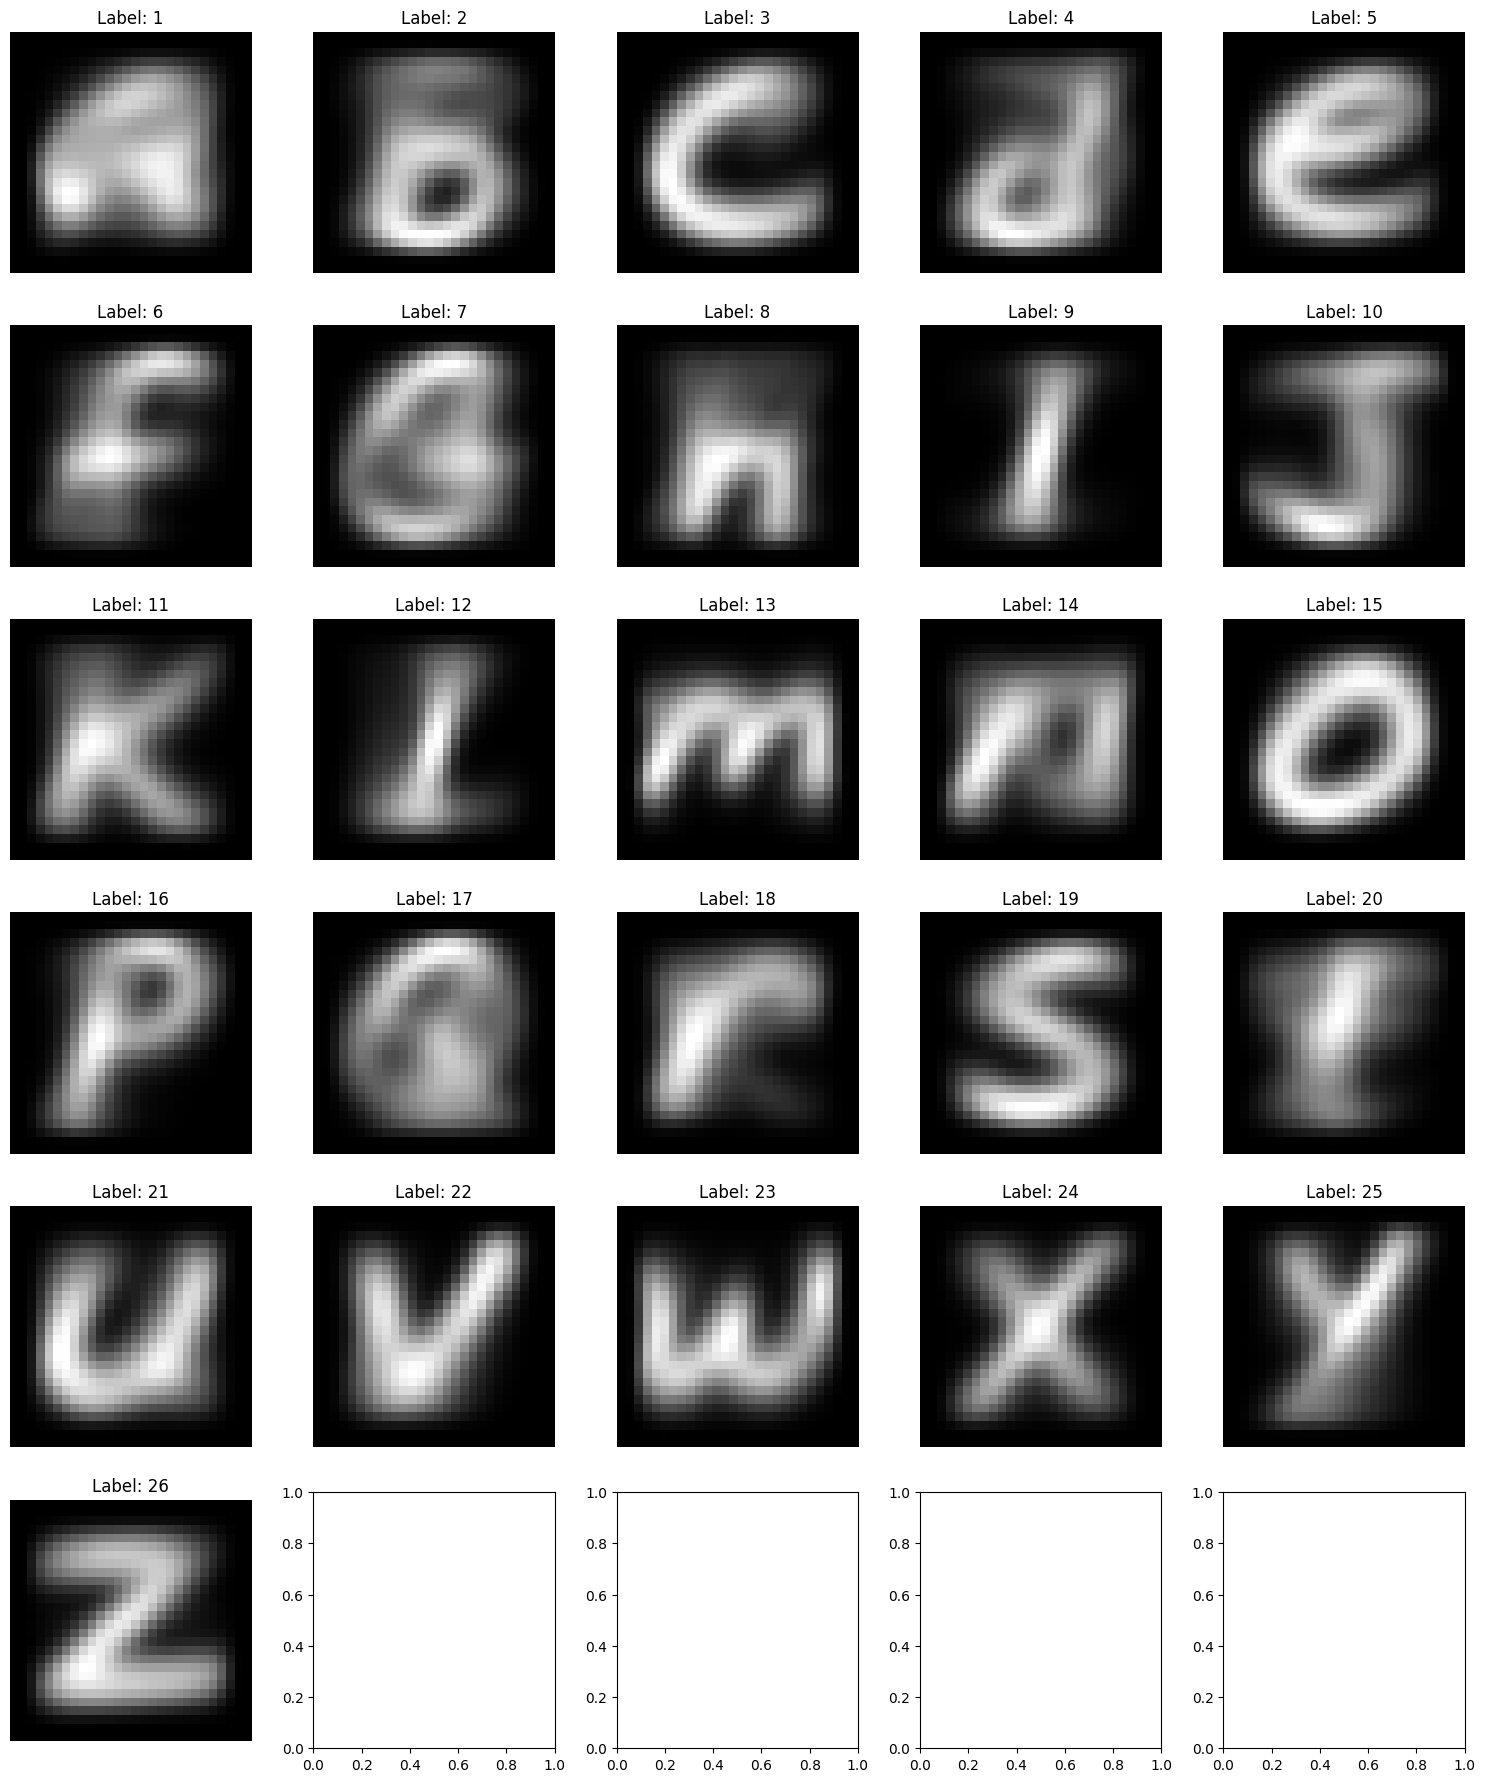

In [10]:
# Get the unique labels
unique_labels = np.unique(labels)

# Create a figure for the average images
fig, axes = plt.subplots(6, 5, figsize=(15, 18))

# Loop through each label and calculate the average image
for i, label in enumerate(unique_labels):
    # Select images for the current label
    selected_images = transposed_images[label == labels]

    # Compute the average image
    average_image = np.mean(selected_images, axis=0)

    # Plot the average image
    row, col = divmod(i, 5)
    axes[row, col].imshow(average_image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

## Blurry Images 
If the average image of a class is blurry, it suggests several key points about your dataset:

- High Variability: There is a high degree of variation in how the images of that class are represented.

-  This could mean that the shapes, sizes, orientations, and positions of the strokes or features vary significantly across the images in that c

## What we learn from the Average Image

Feature Learning: The average images help identify the key features that your model needs to learn for each class. 

For instance, the consistent strokes or shapes that are visible in the average images are crucial features for classification.

Class Distinction: These average images can help you see how distinct or similar different classes are.

If two classes have very similar average images, it might be challenging for the model to distinguish between them, and you may need more discriminative features.

Data Quality: Clear average images indicate good quality and consistency in your dataset. If some classes have very blurred averages, you might need to investigate and possibly clean or augment those classes to improve consistency

## Investigating Class Seperability using PCA, T-SNE

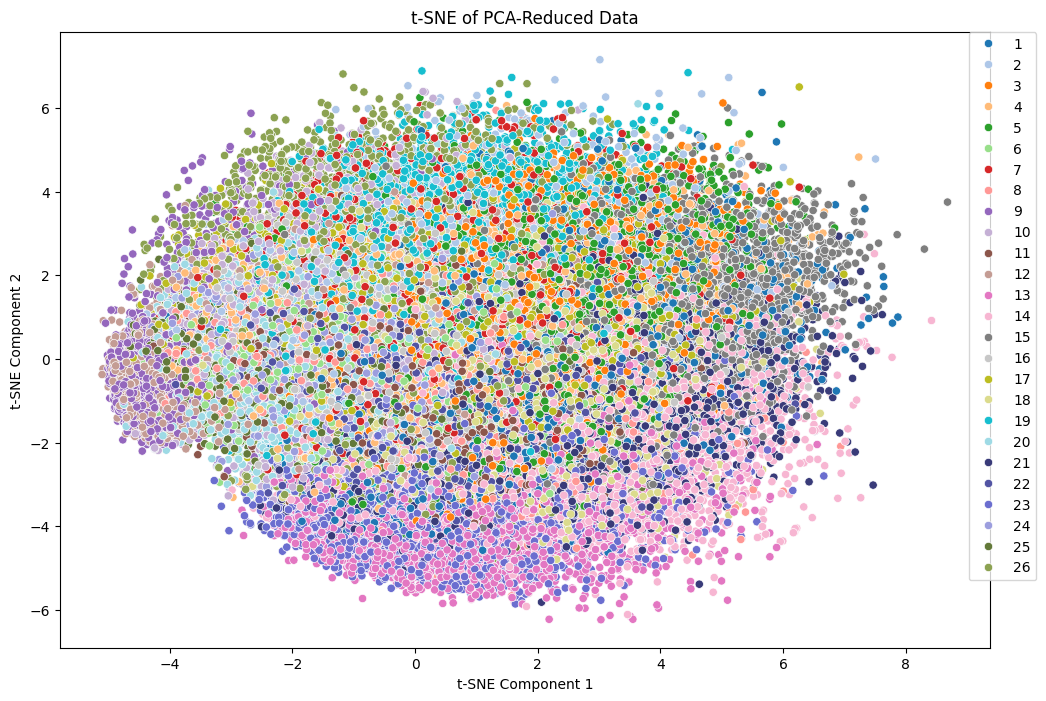

In [11]:
from sklearn.decomposition import PCA

# Flatten images for PCA
flat_images = images.reshape(images.shape[0], -1)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_images)

palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 6)
#  Plot t-SNE results after PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=palette, legend='full')
plt.title('t-SNE of PCA-Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
plt.show()




In [12]:
# from sklearn.manifold import TSNE

# # Apply t-SNE to the flattened images
# # Flatten images for PCA
# images_flatten = images.reshape(len(images), -1)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(images_flatten)

# # Plot t-SNE results
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", legend='full')
# plt.title('t-SNE of Image Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(loc='best')
# plt.show()


In [13]:
# from sklearn.decomposition import PCA
# import seaborn as sns

# # Apply PCA

# # Flatten images for PCA and t-SNE
# images_flatten = images.reshape(len(images), -1)

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(images_flatten)

# # Create a large color palette
# palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 6)

# # Plot PCA results with larger palette
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=palette, legend='full')
# plt.title('PCA of EMNIST Data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
# plt.show()


In [14]:
# # Apply PCA before t-SNE
# from sklearn.manifold import TSNE
# pca_50 = PCA(n_components=50)  # Reduce to 50 dimensions first
# pca_result_50 = pca_50.fit_transform(images_flatten)
# tsne = TSNE(n_components=2, random_state=42)

# # Apply t-SNE on PCA-reduced data
# tsne_pca_result = tsne.fit_transform(pca_result_50)
# # Generate a palette with 40 colors
# palette = sns.color_palette("hsv", 40)
# # Plot t-SNE results after PCA
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=tsne_pca_result[:, 0], y=tsne_pca_result[:, 1], hue=labels, palette=palette, legend='full')
# plt.title('t-SNE of PCA-Reduced Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
# plt.show()


# Feature Engineering

## Edge Detection

- Edge detection is a technique used to identify and locate sharp discontinuities in an image. 

- These discontinuities correspond to significant changes in intensity, which typically represent boundaries of objects within the image.

- The primary goal of edge detection is to capture important features of an image such as lines, curves, and shapes

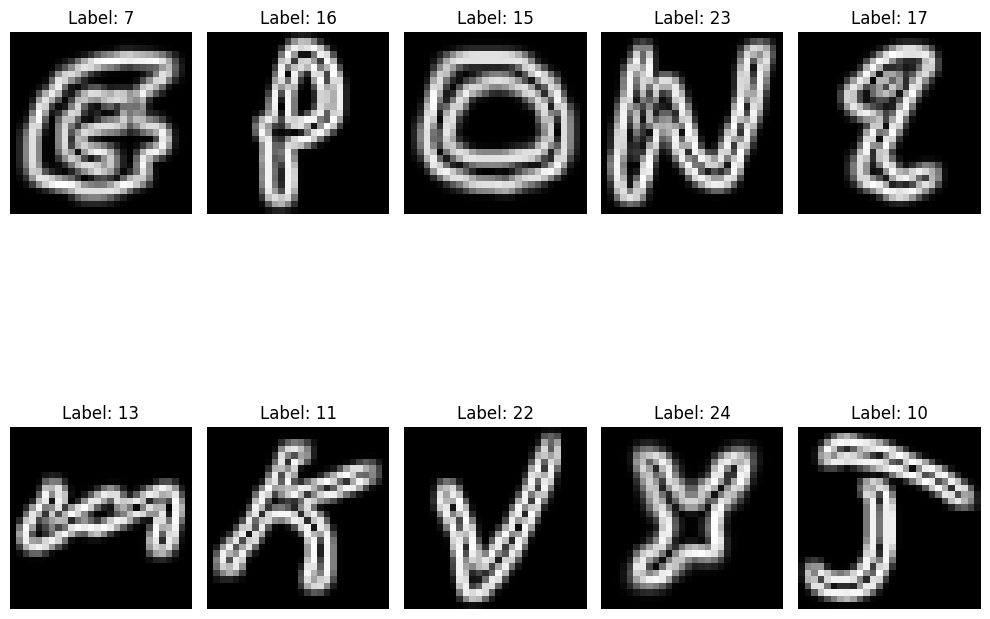

In [15]:
import matplotlib.pyplot as plt
from skimage import filters

# Apply edge detection (Canny filter) to the images
edges = np.array([filters.sobel(image.squeeze()) for image in transposed_images])

# Display some edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(edges[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


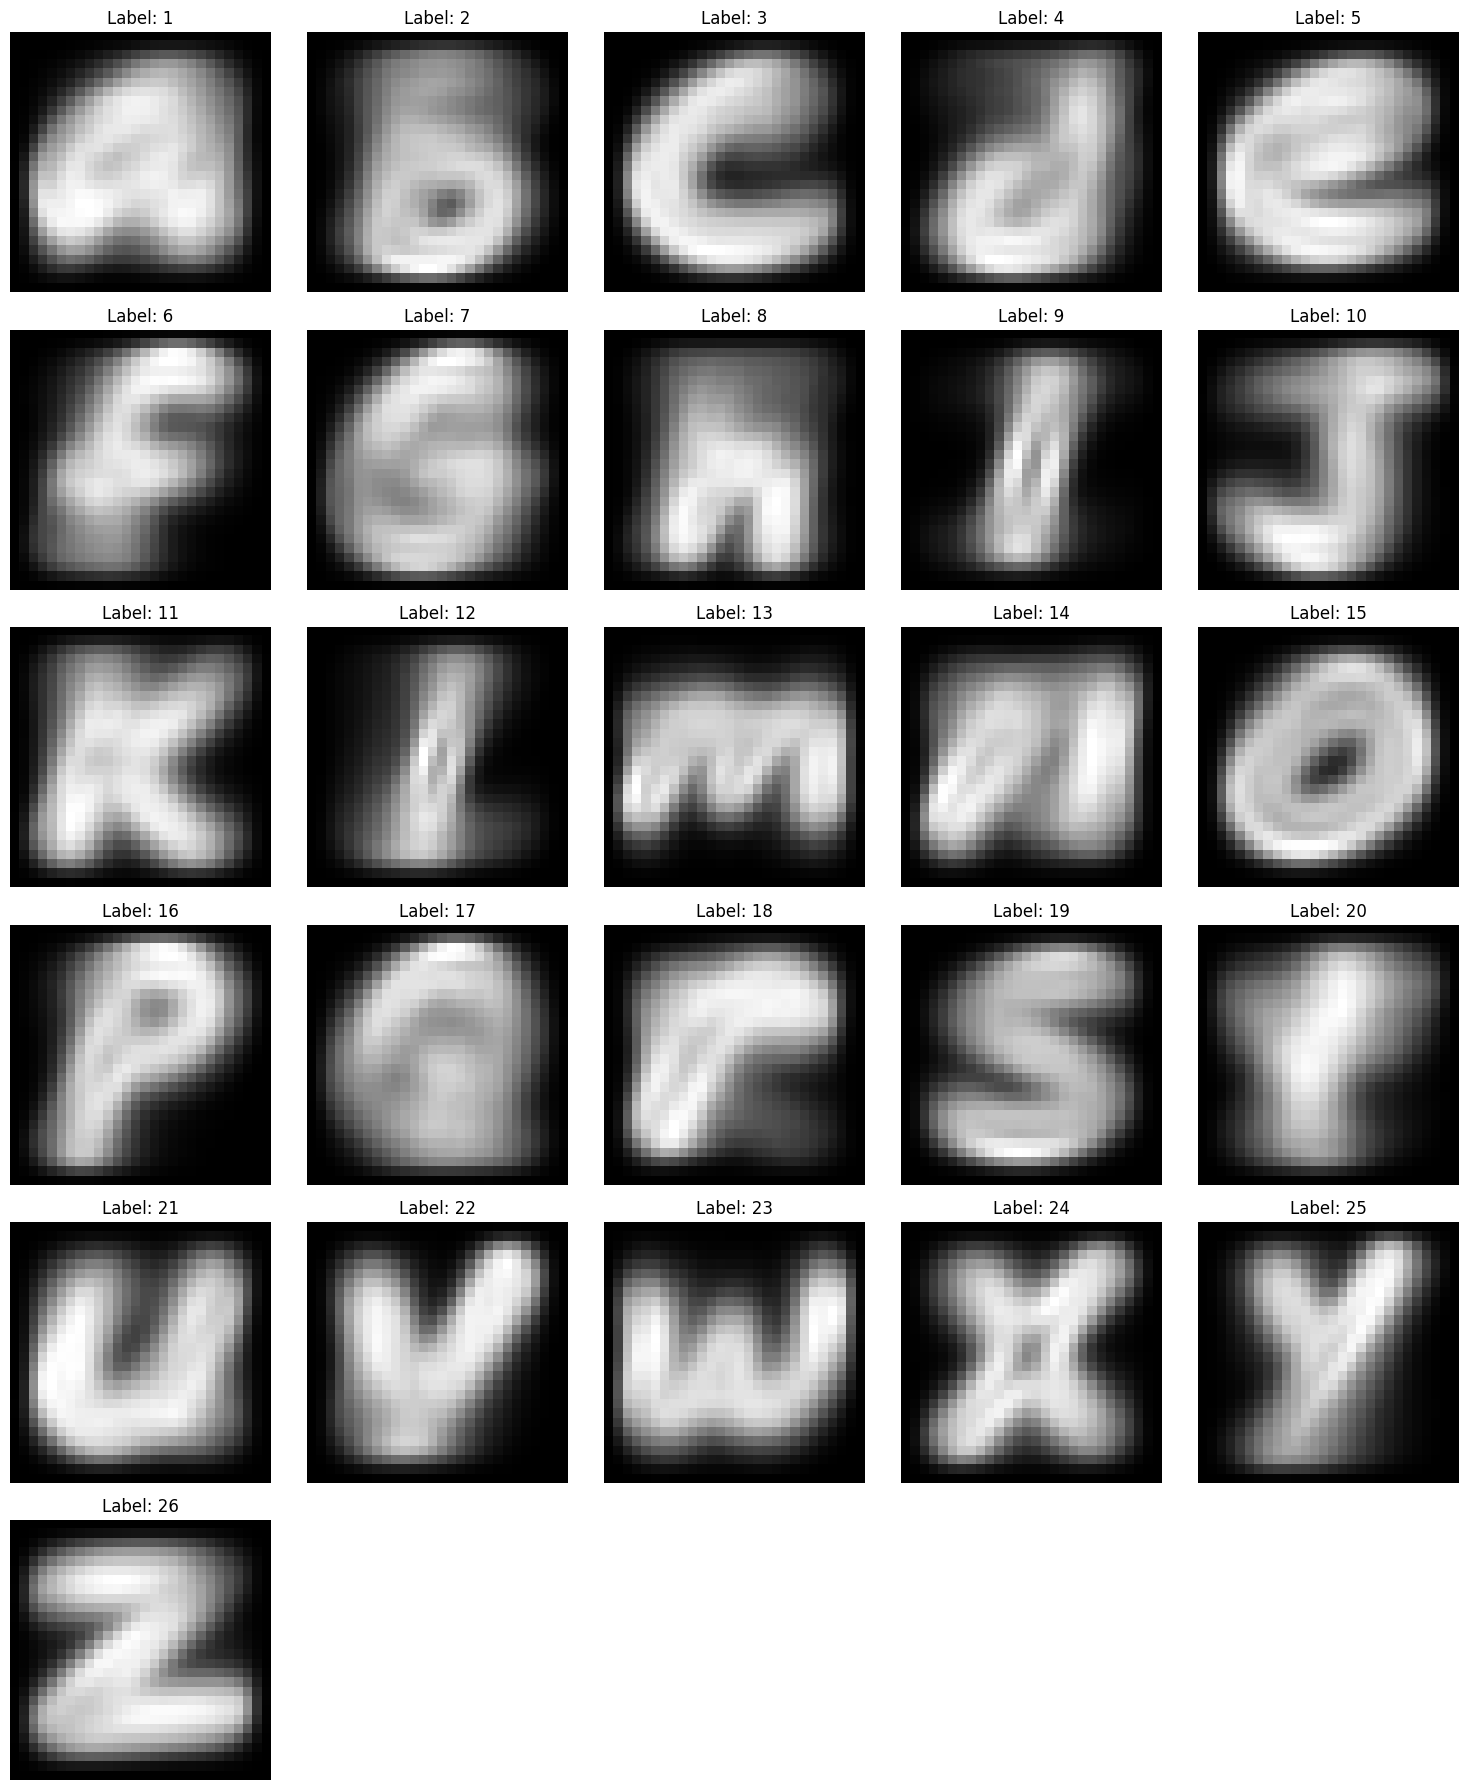

In [16]:
## Get the unique labels
unique_labels = np.unique(labels)

# Dictionary to store average edge images for each class
average_edge_images = {}

# Compute average edge image for each class
for label in unique_labels:
    # Get all images for the current label
    class_edges = edges[labels == label]
    
    # Compute the average edge-detected image for the current label
    average_edge_images[label] = np.mean(class_edges, axis=0)

# Determine the grid size for plotting
num_labels = len(unique_labels)
rows = (num_labels + 4) // 5  # Adjust the number of columns as needed
cols = 5

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Display the average edge-detected images for each class
for i, label in enumerate(unique_labels):
    row, col = divmod(i, cols)
    axes[row, col].imshow(average_edge_images[label], cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Thresholding

- Converts the edge-detected image into a binary format to simplify the representation and make the edges more distinct.

- For instance, using Otsu’s method to find an optimal threshold value, you can binarize the edge-detected image to highlight the detected edges

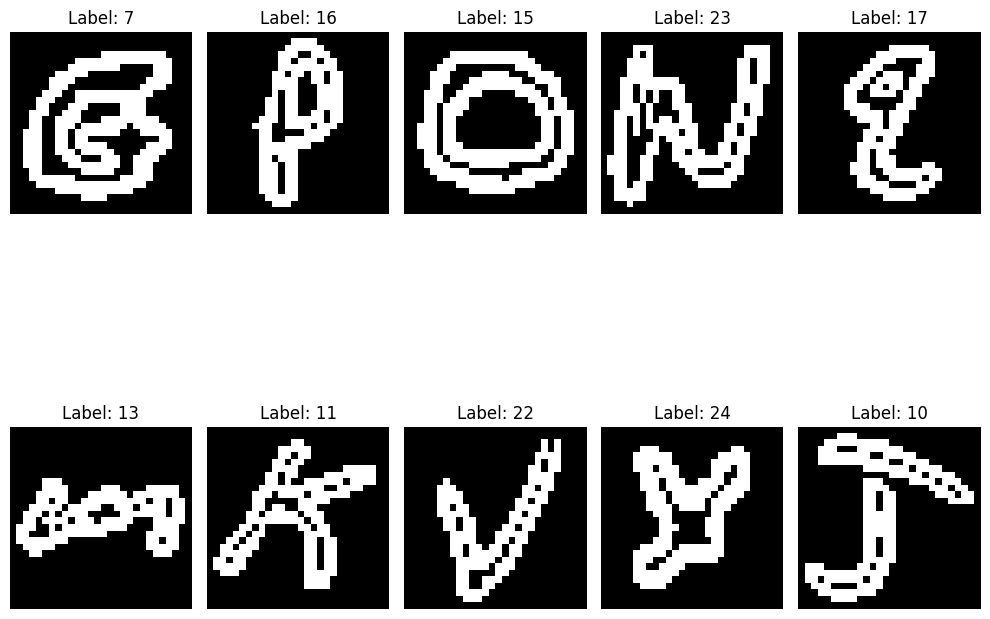

In [17]:
from skimage import filters

# Apply a binary threshold to the edge-detected images
thresholded_edges = [filters.threshold_otsu(edge) for edge in edges]
binary_edges = [(edge > threshold).astype(int) for edge, threshold in zip(edges, thresholded_edges)]

# Display some thresholded edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(binary_edges[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()



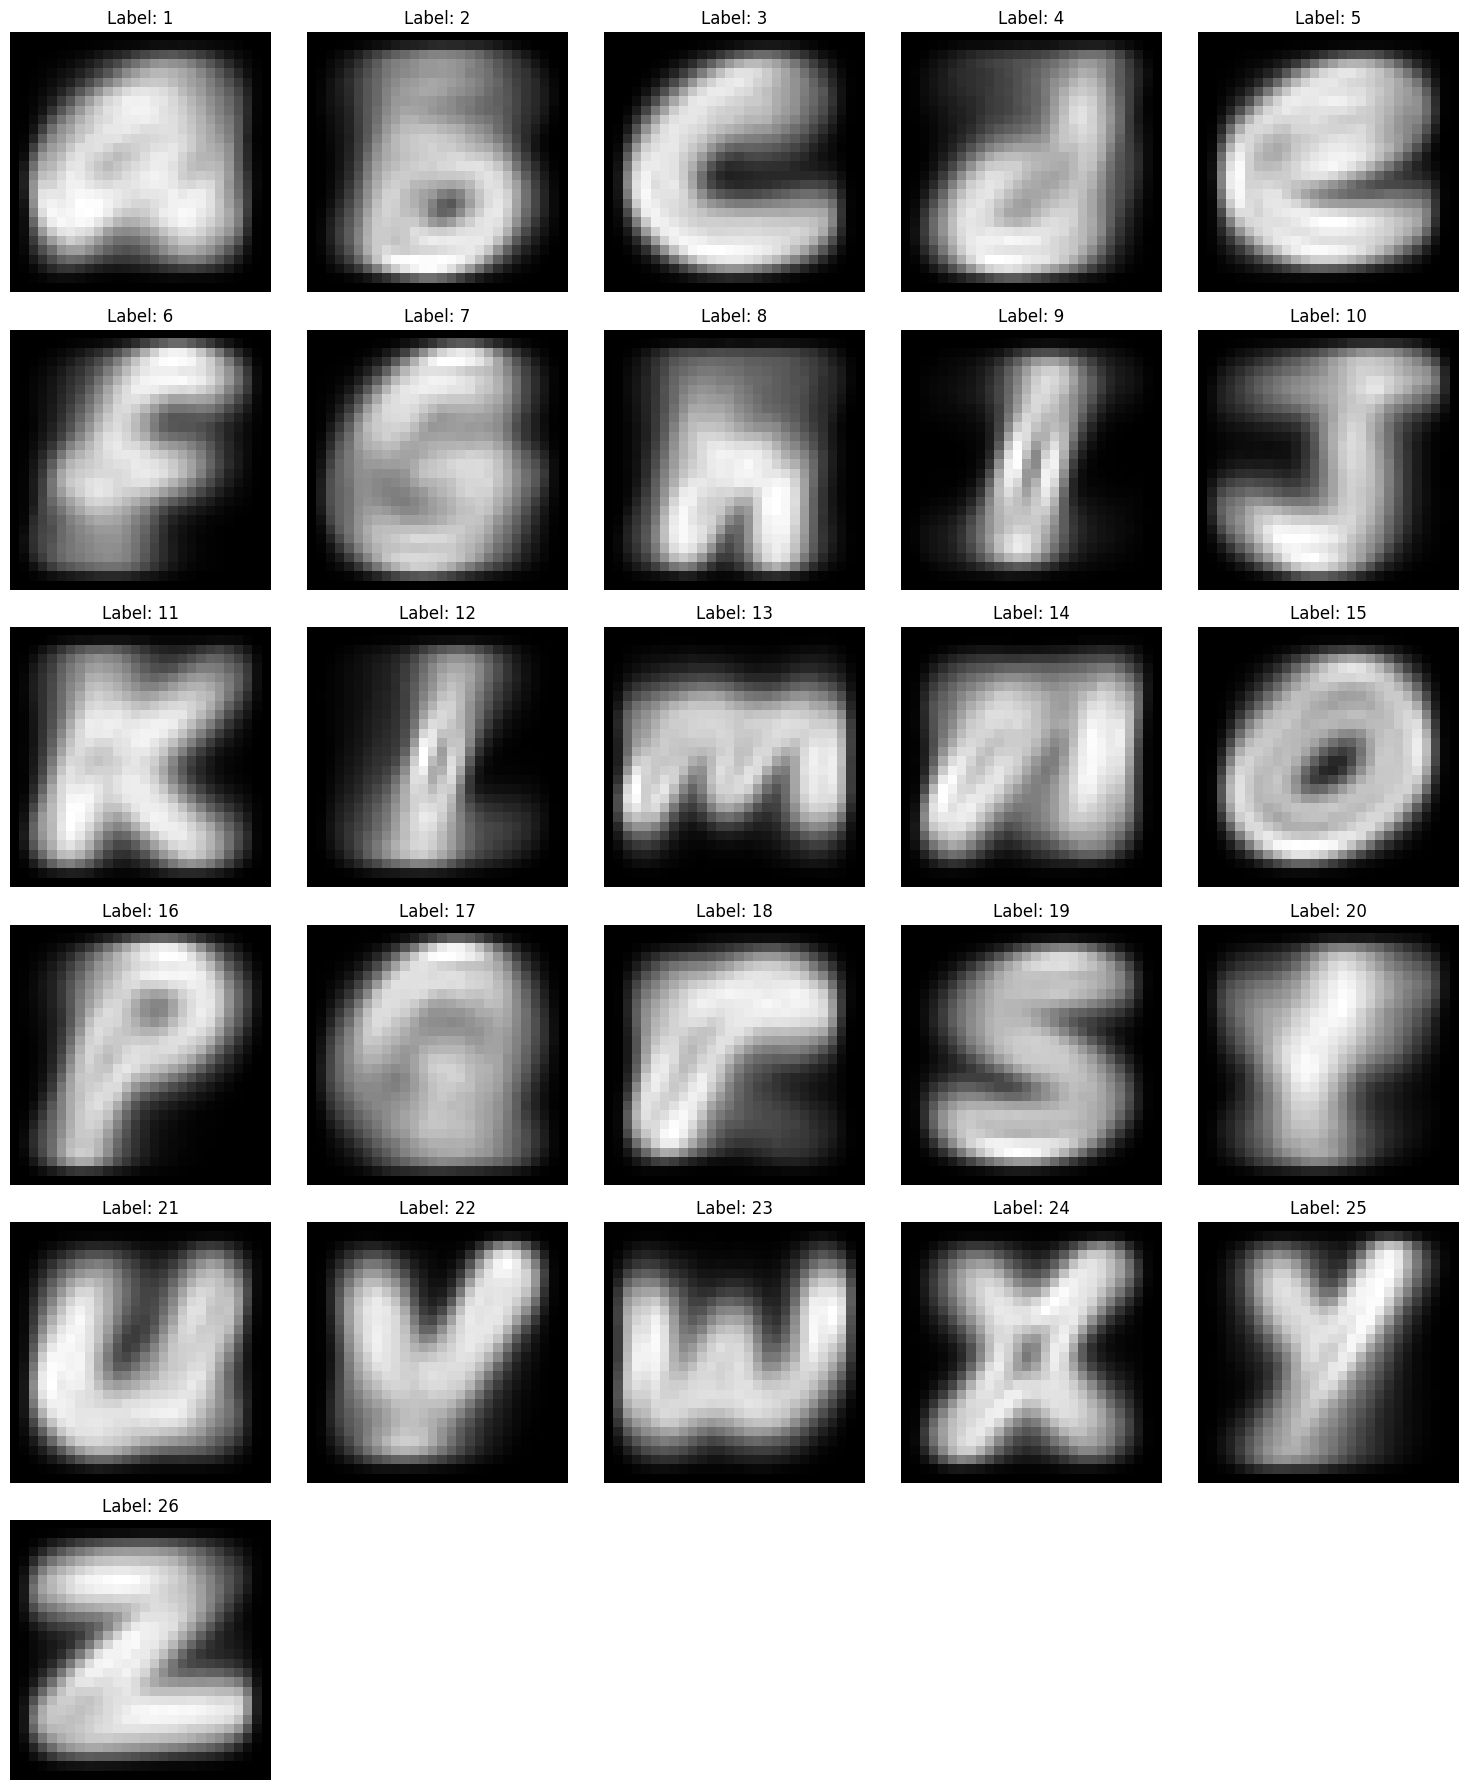

In [18]:
# Get the unique labels
binary_edges = np.array(binary_edges)
unique_labels = np.unique(labels)

# Dictionary to store average binary edge images for each class
average_bedge_images = {}

# Compute average binary edge image for each class
for label in unique_labels:
    # Get all binary edge images for the current label
    class_edges = binary_edges[labels == label]
    
    # Compute the average binary edge-detected image for the current label
    average_bedge_images[label] = np.mean(class_edges, axis=0)

# Determine the grid size for plotting
num_labels = len(unique_labels)
rows = (num_labels + 4) // 5  # Adjust the number of columns as needed
cols = 5

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Display the average binary edge-detected images for each class
for i, label in enumerate(unique_labels):
    row, col = divmod(i, cols)
    axes[row, col].imshow(average_bedge_images[label], cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Model Buildling

Might use condtional GANs because of hard seperabiltiy

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
________________________________

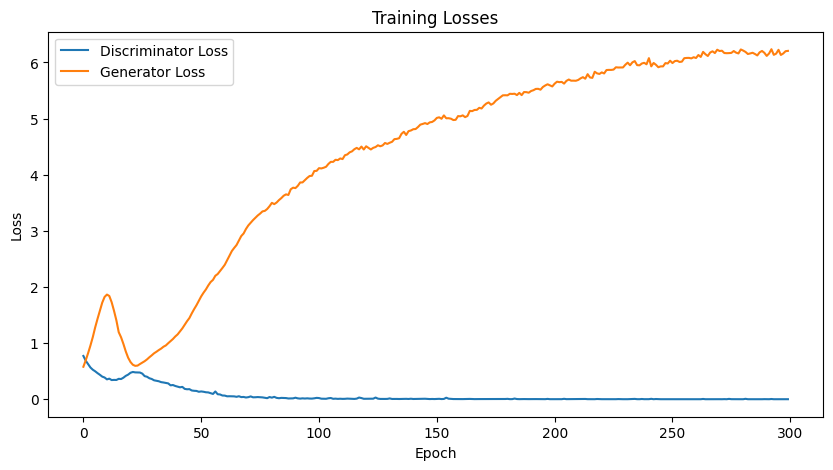

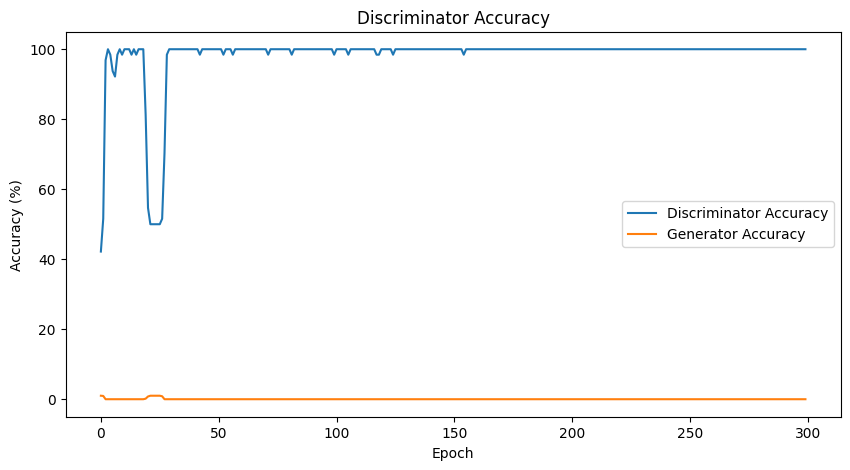

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

class DCGAN:
    
    def __init__(self, rows=28, cols=28, channels=1, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # Latent space dimension (input noise vector size)
        
        # Optimizer for Generator
        g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Optimizer for Discriminator
        d_optimizer = Adam(learning_rate=0.001, beta_1=0.9)  # Adjusted to make discriminator worse
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=d_optimizer,
                                   metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model, we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=g_optimizer)

        # Initialize lists to store losses and accuracy
        self.d_losses = []
        self.g_losses = []
        self.d_accuracies = []
        self.g_accuracies = []

    def build_generator(self):
        model = Sequential(name='Generator')
        
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, transposed_images.shape[0], batch_size)
            imgs = transposed_images[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train Generator
            g_loss = self.combined.train_on_batch(noise, valid)
            # Calculate generator accuracy
            g_acc = self.discriminator.evaluate(gen_imgs, valid, verbose=0)[1]
            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            self.d_accuracies.append(100 * d_loss[1])
            self.g_accuracies.append(g_acc)

            # Plot the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
            
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig(f"generated_mnist/dcgan_mnist_{epoch}.png")
        plt.close()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig(f"generated_mnist/dcgan_mnist_{epoch}.png")
        plt.close()

    def plot_losses(self):
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.plot(self.g_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_accuracies, label="Discriminator Accuracy")
        plt.plot(self.g_accuracies, label="Generator Accuracy")
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.show()

# Instantiate and train the DCGAN
dcgan = DCGAN()
dcgan.train(epochs=300, batch_size=32, save_interval=50)
dcgan.plot_losses()


In [22]:
import matplotlib.pyplot as plt

# Plot Discriminator and Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_loss[0], label='Discriminator Loss')
plt.plot(g_loss[0], label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.legend()
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_loss[1]*100, label='Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Discriminator Accuracy During Training')
plt.legend()
plt.show()


NameError: name 'd_loss' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Generate and plot final images
generate_and_plot_images(generator, input_dim, num_classes)

In [ ]:
print(hog_features)

In [ ]:
print(hog_features.shape)


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator with Augmentations
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotate images
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1, # Shift images vertically
    zoom_range=0.1,         # Zoom into images
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill in pixels after transformations
)

# Fit the generator on the dataset
datagen.fit(images)

# Example of applying augmentations
augmented_images, _ = next(datagen.flow(images, labels, batch_size=10))

# Plot some augmented images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
